## Inference Stage
This notebook demonstrates what happens when you call `run_inference.py`.

Make sure you have completed the setup instructions in `README.md` before running this notebook. Run the notebook from the cnos25 repo root directory.
You also want to have reference descriptors readily extracted from the onboarding step.

In [3]:
import os
import logging
from omegaconf import DictConfig, OmegaConf
import hydra
from torch.utils.data import DataLoader

from src.utils.imgproc import pilImageRow

### Loading the configuration from `configs/run_inference.yaml`
This is done automatically when you call `run_inference.py`.

In [4]:
config_dir = os.path.abspath("./configs")

with hydra.initialize_config_dir(config_dir=config_dir, version_base=None):
    cfg = hydra.compose(config_name="run_inference", overrides=["dataset_name=hopev2", "split=val"])

### Instantiation of query dataloader

In [5]:
def init_query_dataloader():
    OmegaConf.set_struct(cfg, False) # allows adding new keys
    query_dataloader_config = cfg.data.query_dataloader.copy()
    query_dataloader_config.dataset_name = cfg.dataset_name
    query_dataloader_config.split = cfg.split
    query_dataloader_config.root_dir += f"{cfg.dataset_name}"
    query_dataset = hydra.utils.instantiate(query_dataloader_config)
    no_collate = lambda batch: batch # don't convert to tensor/device
    query_dataloader = DataLoader(
        query_dataset,
        batch_size=1,  # only support a single image for now
        num_workers=cfg.local.num_workers,
        collate_fn=no_collate,
        shuffle=False,
    )
    return query_dataloader

query_dataloader = init_query_dataloader()

Loading target file: /mnt/external/datasets/bop/hopev2/val_targets_bop24.json


Loading metaData: 100%|█| 10/10 [00:00<00:00, 42


### Instantiation of model

In [6]:
model = hydra.utils.instantiate(cfg.model)

### Step-by-step inference
That's what `inference_loop` in `run_inference.yaml` is doing.

#### 1. Load a sample

demo_sample={'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1920x1080 at 0x7F76FAC6B190>, 'scene_id': '000010', 'frame_id': 0}
demo_sample["image"].size=(1920, 1080)


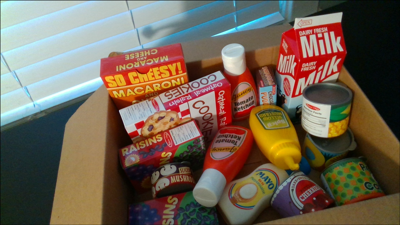

In [7]:
demo_sample = next(iter(query_dataloader))[0]

# show
print(f'{demo_sample=}')
print(f'{demo_sample["image"].size=}')
pilImageRow(demo_sample["image"], maxwidth=400)

#### 2. Proposal stage
returns a `src.utils.detection_utils.Detections` object

In [8]:
proposals = model.proposal_fwd_pass(demo_sample['image'])

proposals

It stores `boxes` and `masks`:

In [9]:
proposals.boxes.shape, proposals.masks.shape

(torch.Size([24, 4]), torch.Size([24, 1080, 1920]))

#### 3. DINO descriptor extraction for proposals

In [10]:
proposal_descriptors = model.dino_fwd_pass(demo_sample['image'], proposals)

proposal_descriptors.shape

torch.Size([24, 1024])

#### 4. Classification through matching proposals <-> templates

In [11]:
score_per_proposal, assigned_idx_object = model.classify(proposal_descriptors)

In [12]:
score_per_proposal, assigned_idx_object

(tensor([0.8726, 0.7462, 0.8221, 0.7289, 0.8584, 0.7122, 0.9111, 0.7496, 0.6688, 0.6527, 0.8349, 0.7127, 0.8352, 0.5688, 0.7645, 0.6530, 0.7359, 0.5446, 0.5403, 0.7314, 0.6271, 0.7267, 0.2456, 0.6930], device='cuda:0'),
 tensor([10, 22, 13, 14, 10, 22, 15, 12,  3,  5,  6,  3,  4, 20, 12, 11, 19,  5,  8, 19,  2, 14, 21, 22], device='cuda:0'))

In [13]:
from src.utils.visualization_detectron2 import CNOSVisualizer
import numpy as np
from PIL import Image

def show_results(top_n=16):
    visualizer = CNOSVisualizer(cfg.data.datasets[cfg.dataset_name].obj_names, img_size=np.array(demo_sample['image']).shape[:2])
    visualizer.forward(rgb=np.array(demo_sample['image']), 
                       masks=proposals.masks.cpu().numpy()[:top_n], 
                       bboxes=proposals.boxes.cpu().numpy()[:top_n], 
                       scores=score_per_proposal[:top_n], 
                       labels=assigned_idx_object[:top_n],
                       save_path='/tmp/demo_inference.png')
    display(Image.open('/tmp/demo_inference.png'))

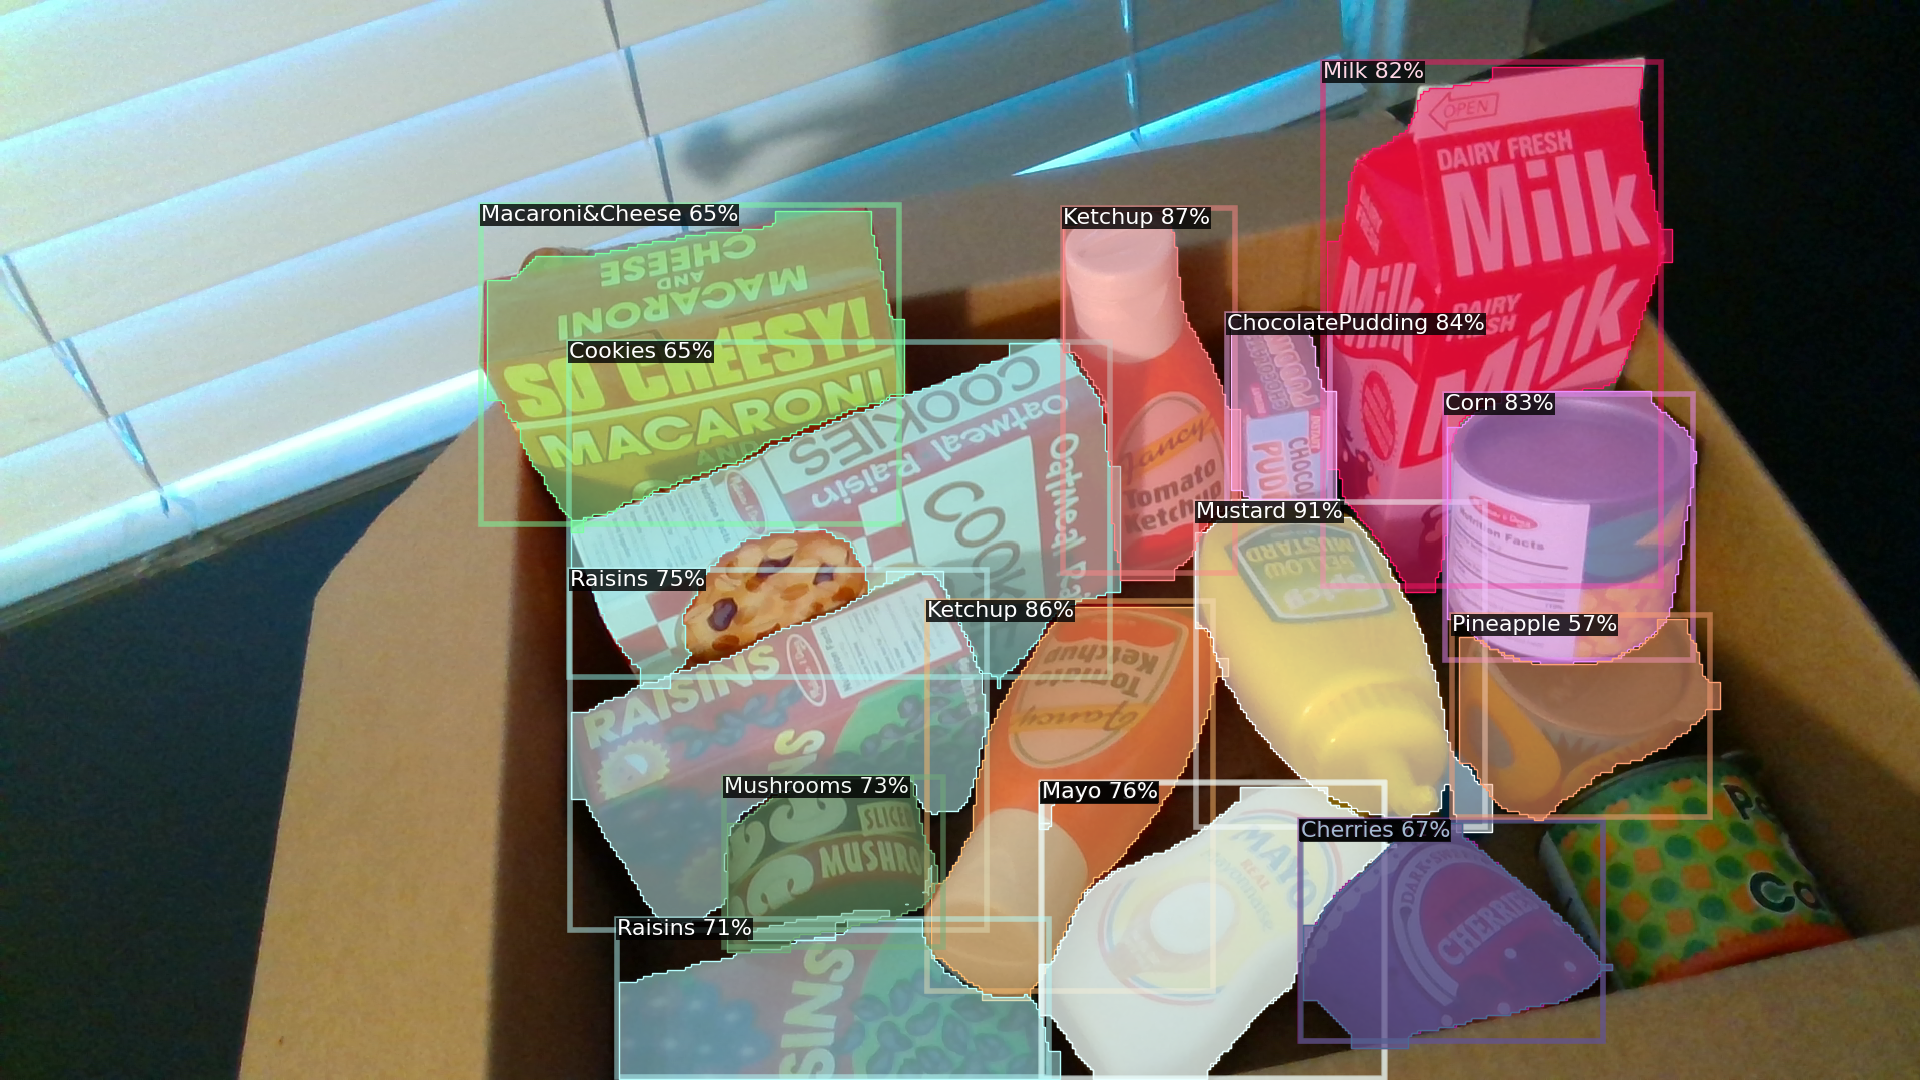

In [14]:
show_results()

### Done!